# Segmentación de Clientes con Segmentación Manual

En este notebook se utiliza una base de datos de e-commerce para segmentar clientes de forma manual a partir de las métricas calculadas en el análisis:

- **Total Revenue**: Ingreso total por cliente.
- **Total Units**: Cantidad total de productos comprados.
- **NumCategories**: Número de categorías (diversidad de productos) compradas.

Además, se agrupa la variable numérica **age** con pd.cut para ver cómo se distribuyen las compras en función de grupos etarios.

El objetivo es definir segmentos (por ejemplo, "Bajo", "Medio" y "Alto" en Total Revenue) que sirvan para orientar estrategias de negocio, sin utilizar algoritmos de clustering complejos.

In [5]:
!wget https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/customer_shopping_data.csv.zip
!unzip customer_shopping_data.csv.zip

--2025-03-27 21:19:38--  https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/customer_shopping_data.csv.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/customer_shopping_data.csv.zip [following]
--2025-03-27 21:19:38--  https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/customer_shopping_data.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1712272 (1.6M) [application/zip]
Saving to: ‘customer_shopping_data.csv.zip.1’

c

In [8]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
%matplotlib inline
sns.set(style='whitegrid')

## 1. Carga y Preprocesamiento de Datos

Utilizamos una base de datos sintética basada en la siguiente estructura:

- **invoice_no**
- **customer_id**
- **gender**
- **age**
- **category**
- **quantity**
- **price**
- **payment_method**
- **invoice_date**
- **shopping_mall**

Se convierte la fecha a datetime y se calcula la métrica *Revenue* (quantity * price).

In [90]:
# Crear DataFrame con datos de ejemplo
df = pd.read_csv('customer_shopping_data.csv')
data = df.copy()

In [91]:
data

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon
...,...,...,...,...,...,...,...,...,...,...
99452,I219422,C441542,Female,45,Souvenir,5,58.65,Credit Card,21/09/2022,Kanyon
99453,I325143,C569580,Male,27,Food & Beverage,2,10.46,Cash,22/09/2021,Forum Istanbul
99454,I824010,C103292,Male,63,Food & Beverage,2,10.46,Debit Card,28/03/2021,Metrocity
99455,I702964,C800631,Male,56,Technology,4,4200.00,Cash,16/03/2021,Istinye Park


In [92]:

# Convertir invoice_date a datetime
df['invoice_date'] = pd.to_datetime(df['invoice_date'], format='%d/%m/%Y')

# Calcular Revenue
df['Revenue'] = df['quantity'] * df['price']

print('Datos transaccionales:')
df

Datos transaccionales:


,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,Revenue
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,2022-08-05,Kanyon,7502.00
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul,5401.53
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,2021-11-09,Metrocity,300.08
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,2021-05-16,Metropol AVM,15004.25
4,I337046,C189076,Female,53,Books,4,60.60,Cash,2021-10-24,Kanyon,242.40
...,...,...,...,...,...,...,...,...,...,...,...
99452,I219422,C441542,Female,45,Souvenir,5,58.65,Credit Card,2022-09-21,Kanyon,293.25
99453,I325143,C569580,Male,27,Food & Beverage,2,10.46,Cash,2021-09-22,Forum Istanbul,20.92
99454,I824010,C103292,Male,63,Food & Beverage,2,10.46,Debit Card,2021-03-28,Metrocity,20.92
99455,I702964,C800631,Male,56,Technology,4,4200.00,Cash,2021-03-16,Istinye Park,16800.00


## 2. Análisis Exploratorio

Utilizamos pivot tables y crosstabs para explorar la distribución de ingresos y transacciones por diferentes dimensiones.

In [93]:

pivot_mean = pd.pivot_table(
    df,
    values='Revenue',
    index="shopping_mall",
    columns='category',
    aggfunc='sum',
    fill_value=0
)
print('Promedio por categoría:')
pivot_mean


Promedio por categoría:


category,Books,Clothing,Cosmetics,Food & Beverage,Shoes,Souvenir,Technology,Toys
shopping_mall,,,,,,,,
Cevahir AVM,44541.00,5706321.28,321214.00,44010.45,3243918.85,29723.82,3051300.0,204108.80
Emaar Square Mall,41995.80,5590490.40,338941.76,40610.95,3089675.16,30943.74,3094350.0,179092.48
Forum Istanbul,42056.40,5792444.24,353172.76,39162.24,3327942.65,32879.19,2516850.0,199413.76
Istinye Park,76083.30,11253900.24,655357.88,85918.44,6641481.22,68925.48,5436900.0,400261.12
Kanyon,163029.15,22609527.60,1369550.78,166497.05,13383190.83,127399.53,11944800.0,790236.16
Mall of Istanbul,172240.35,22947417.68,1367517.78,171177.90,13467814.80,127540.29,11828250.0,790522.88
Metrocity,125911.65,17226692.56,991860.04,129902.74,9519296.37,94227.09,8608950.0,605946.88
Metropol AVM,83718.90,11568084.00,680770.38,88638.04,7149825.21,67869.78,5327700.0,413306.88
Viaport Outlet,39632.40,5604594.16,347439.70,41662.18,3194704.91,27319.17,3066000.0,199987.20


## 3. Agregación a Nivel de Cliente

Agrupamos las transacciones por **customer_id** y **category** para obtener la cantidad total de cada producto comprado por cliente.

In [94]:
df.groupby(['customer_id', 'category']).agg({'quantity': 'sum'}).reset_index()


,customer_id,category,quantity
0,C100004,Clothing,5
1,C100005,Shoes,2
2,C100006,Toys,3
3,C100012,Food & Beverage,5
4,C100019,Toys,1
...,...,...,...
99452,C999886,Food & Beverage,3
99453,C999910,Books,3
99454,C999974,Clothing,5
99455,C999976,Toys,3


### Crear tabla a nivel de cliente (formato ancho)

Convertimos la tabla agrupada en un formato ancho: cada fila es un cliente y cada columna es una categoría. Esto facilita el análisis comparativo.

In [95]:
 tabla_ancha= pd.pivot_table(
    df,
    values='quantity',
    index='customer_id',
    columns='category',
    aggfunc='sum',
    fill_value=0
)


In [96]:
tabla_ancha

category,Books,Clothing,Cosmetics,Food & Beverage,Shoes,Souvenir,Technology,Toys
customer_id,,,,,,,,
C100004,0,5,0,0,0,0,0,0
C100005,0,0,0,0,2,0,0,0
C100006,0,0,0,0,0,0,0,3
C100012,0,0,0,5,0,0,0,0
C100019,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
C999886,0,0,0,3,0,0,0,0
C999910,3,0,0,0,0,0,0,0
C999974,0,5,0,0,0,0,0,0


## 4. Transformación con Melt: Formato Largo

Convertimos la tabla ancha a formato largo para obtener un DataFrame con tres columnas: `customer_id`, `category` y `quantity`. Este formato es útil para visualizar la distribución de compras por cliente.

In [97]:
tabla_largo = pd.melt( tabla_ancha.reset_index(),
    id_vars='customer_id',
    var_name='category',
    value_name='quantity'
)

In [98]:
tabla_largo

,customer_id,category,quantity
0,C100004,Books,0
1,C100005,Books,0
2,C100006,Books,0
3,C100012,Books,0
4,C100019,Books,0
...,...,...,...
795651,C999886,Toys,0
795652,C999910,Toys,0
795653,C999974,Toys,0
795654,C999976,Toys,3


## 5. Segmentación Manual usando pd.cut

Utilizaremos pd.cut para segmentar a los clientes en función de su **Total Revenue**. Definiremos 3 grupos:

- **Bajo**: Clientes con ingresos bajos.
- **Medio**: Clientes con ingresos moderados.
- **Alto**: Clientes con altos ingresos.

Calculamos las métricas a nivel de cliente y aplicamos pd.cut para crear la variable *RevenueSegment*.

Además, agrupamos la variable **age** en intervalos para ver la distribución de segmentos por grupo etario.

In [99]:
df["RevenueSegment"]= pd.cut(df['Revenue'], bins=3, labels=['Bajo', 'Medio', 'Alto'])

In [100]:
df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,Revenue,RevenueSegment
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,2022-08-05,Kanyon,7502.00,Bajo
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul,5401.53,Bajo
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,2021-11-09,Metrocity,300.08,Bajo
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,2021-05-16,Metropol AVM,15004.25,Medio
4,I337046,C189076,Female,53,Books,4,60.60,Cash,2021-10-24,Kanyon,242.40,Bajo


Además, agrupamos la edad en intervalos para complementar la segmentación.

## 6. Visualización Final de la Segmentación

Mostramos una gráfica de barras que resuma la cantidad de clientes en cada segmento de ingresos (*RevenueSegment*). Esta visualización permite identificar de forma rápida qué grupo es el predominante.

In [101]:
df["edad"] = pd.cut(df["age"], bins=3, labels=['Joven', 'Adulto', 'Mayor'])

In [102]:
df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,Revenue,RevenueSegment,edad
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,2022-08-05,Kanyon,7502.00,Bajo,Joven
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul,5401.53,Bajo,Joven
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,2021-11-09,Metrocity,300.08,Bajo,Joven
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,2021-05-16,Metropol AVM,15004.25,Medio,Mayor
4,I337046,C189076,Female,53,Books,4,60.60,Cash,2021-10-24,Kanyon,242.40,Bajo,Mayor


In [106]:
crosstab_revenue = pd.crosstab(df['RevenueSegment'], df['edad'])
crosstab_revenue

edad,Joven,Adulto,Mayor
RevenueSegment,,,
Bajo,32028,30490,29893
Medio,2076,2036,1933
Alto,314,350,337


<Axes: xlabel='edad', ylabel='RevenueSegment'>

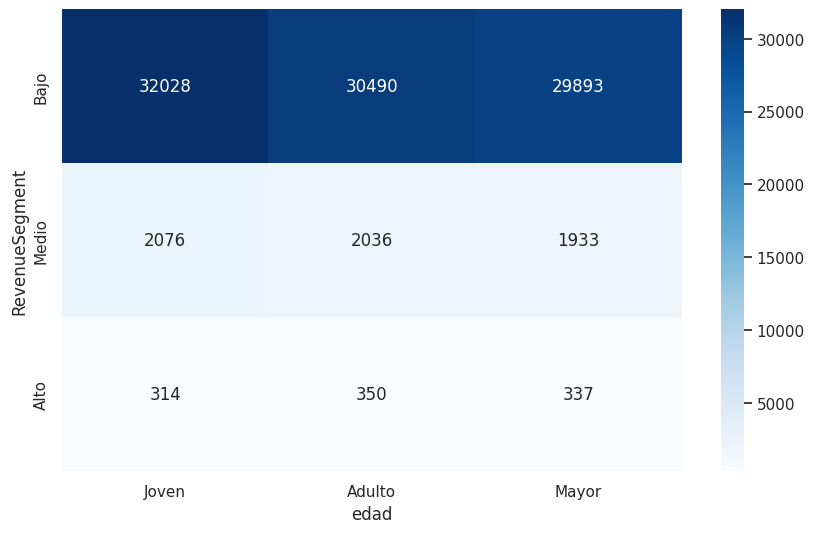

In [107]:

tabla_edad = pd.crosstab(df['RevenueSegment'], df['edad'])
plt.figure(figsize=(10, 6))
sns.heatmap(tabla_edad, annot=True, fmt="d", cmap="Blues",
            xticklabels=tabla_edad.columns,
            yticklabels=tabla_edad.index)

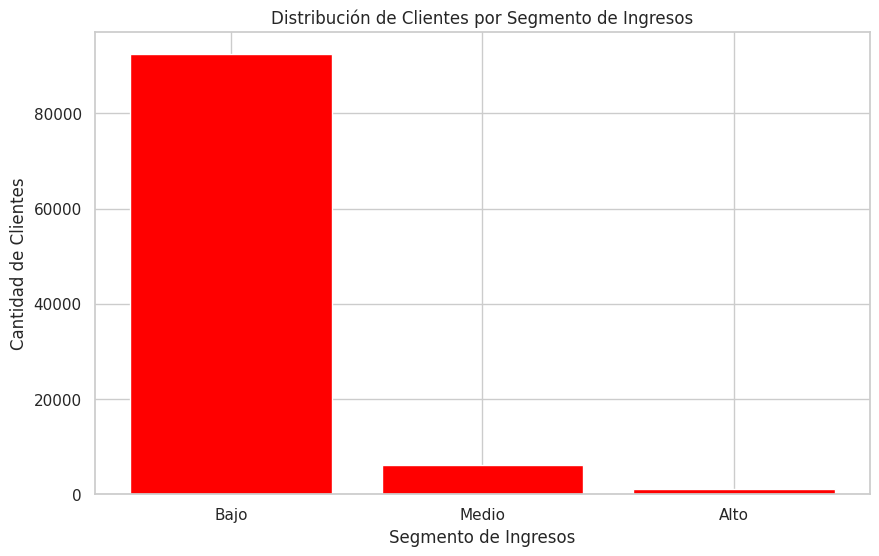

In [105]:
plt.figure(figsize=(10, 6))
color = sns.color_palette('flare')
plt.bar(crosstab_revenue.index, crosstab_revenue.sum(axis=1), color = "red")
plt.xlabel('Segmento de Ingresos')
plt.ylabel('Cantidad de Clientes')
plt.title('Distribución de Clientes por Segmento de Ingresos')
plt.show()

## 7. Conclusiones y Siguientes Pasos

### Insights Obtenidos:

- La segmentación manual usando **pd.cut** permite clasificar a los clientes según su ingreso total, lo que puede ayudar a identificar clientes de alto valor para campañas de fidelización.
- La crosstab entre grupos de edad y segmentos de ingresos revela cómo varían los patrones de compra en función de la edad.

### Siguientes Pasos:

1. Profundizar en cada segmento analizando otros comportamientos (por ejemplo, diversidad de categorías y métodos de pago).
2. Diseñar estrategias de marketing específicas para cada segmento.
3. Integrar estos insights en dashboards interactivos para monitoreo en tiempo real.

Con este flujo de trabajo se demuestra cómo, sin necesidad de algoritmos avanzados, se puede segmentar a los clientes usando reglas definidas y herramientas de transformación de datos en **pandas**. ¡Éxito en tu análisis!